# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie_gris, load_ismip6_gris, load_imbie_ant, load_ismip6_ant
from utilities.helper import hist_start, hist_end, proj_start, proj_end, proj_time, secpera

import warnings
warnings.filterwarnings('ignore')

## Plotting helpers

In [3]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
grace_signal_color = "#084594"
grace_sigma_color = "#9ecae1"
mouginot_signal_color = "#a63603"
mouginot_sigma_color = "#fdbe85"
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = [26, 85]
rcp_dict = {26: "RCP 2.6", 45: "RCP 4.5", 85: "RCP 8.5"}
rcp_col_dict = {85: "#990002", 45: "#5492CD", 26: "#003466"}
rcp_shade_col_dict = {85: "#F4A582", 45: "#92C5DE", 26: "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 Greenland projections

In [4]:
ismip6_gris = load_ismip6_gris(remove_ctrl=True)
ismip6_gris_w_ctrl = load_ismip6_gris(remove_ctrl=False)

## ISMIP6 in numbers

In [5]:
ng = len(ismip6_gris.groupby(by="Group").mean())
nm = len(ismip6_gris.groupby(by="Model").mean())
ne = len(ismip6_gris.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [6]:
imbie_gris = load_imbie_gris()

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [7]:
def plot_historical(out_filename, df, imbie):
    """
    Plot historical simulations and observations.
    """

    def plot_signal(g):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df["Cumulative ice sheet mass change (Gt)"]

        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    xmin = 2000
    xmax = 2025
    ymin = -3000
    ymax = 4000

    fig = plt.figure(num="historical", clear=True)
    ax = fig.add_subplot(111)

    
    [plot_signal(g) for g in df.groupby(by=["Group", "Model", "Exp"])]

    ismip6_mean = df.groupby(by="Year").mean()
    ismip6_std = df.groupby(by="Year").std()
    ismip6_low = df.groupby(by="Year").quantile(0.05)
    ismip6_high = df.groupby(by="Year").quantile(0.95)


    ismip6_ci = ax.fill_between(
        ismip6_mean.index,
        ismip6_low["Cumulative ice sheet mass change (Gt)"],
        ismip6_high["Cumulative ice sheet mass change (Gt)"],
        color="0.0",
        alpha=0.30,
        linewidth=0.0,
        zorder=10,
        label="Simulated (ISMIP6) 90% c.i."
    )

    ax.fill_between(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        - 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        + 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=imbie_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    imbie_line = ax.plot(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=imbie_signal_color,
        linewidth=imbie_signal_lw,
        label="Observed (IMBIE)",
    )

    ax.axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
    ax.axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)
    ax.text(2014.75, 3000, "Historical Period", ha="right")
    ax.text(2015.25, 3000, "Projection Period", ha="left")

    model_line = mlines.Line2D([], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated (ISMIP6)")

    legend = ax.legend(handles=[imbie_line[0], model_line, ismip6_ci], loc="lower left")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    ax.set_xlabel("Year")
    ax.set_ylabel(f"Cumulative mass change\nsince {proj_start} (Gt)")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax_sle = ax.twinx()
    ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
    ax_sle.set_ylim(-ymin * gt2cmSLE, -ymax * gt2cmSLE)

    set_size(5, 2.5)

    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

TypeError: 'quantile' cannot be performed against 'object' dtypes!

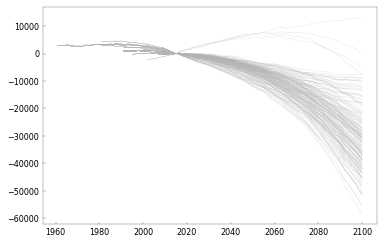

In [8]:
historical_filename = "GRIS_historical_w_ctrl.pdf"
plot_historical(historical_filename, ismip6_gris_w_ctrl, imbie_gris)

In [ ]:
historical_filename = "GRIS_historical.pdf"
plot_historical(historical_filename, ismip6_gris, imbie_gris)

Unfortunately, most simulations underestimate recent (2008--2020) mass loss. Indeed, the observed record of mass loss lies beyond the 95th percentile of the ISMIP6 experiments. Underestimating recent mass loss likely translates into underestimating mass loss at 2100 as well.  That observations and the ensemble are disjoint implies that model uncertainty is underestimated both now and in the future. 

## Comparison between model and parametric uncertainty

Let us now compare model uncertainty and parametric uncertainty. Here we will use the 500 member ensemble of Aschwanden et al. (2019) [AS19]. We start by loading the AS19 data set.

In [ ]:
as19_norm = pd.read_csv("as19/aschwanden_et_al_2019_les_2015_norm.csv.gz")
as19_norm["SLE (cm)"] = -as19_norm["Mass (Gt)"] / 362.5 / 10
as19_norm = as19_norm.astype({"RCP": int, "Experiment": int})

samples_file = "lhs_samples/lhs_samples_500.csv"
samples = pd.read_csv(samples_file).rename(columns={"id": "Experiment"})

as19_norm = pd.merge(as19_norm, samples, on="Experiment")


In [9]:
ismip6_ant = load_ismip6_ant(remove_ctrl=True)

ismip6_ant_ctrl_removed.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV
ComputedScalarsPaper/UCIJPL/ISSM/exp13/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp13.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp12/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp12.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA6/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA6.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA8/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA8.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA7/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA7.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp01/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp01.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp06/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp06.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp08/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp08.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp09/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp09.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp07/compu

ComputedScalarsPaper/DOE/MALI/exp07/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp07.nc
ComputedScalarsPaper/DOE/MALI/exp10/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp10.nc
ComputedScalarsPaper/DOE/MALI/exp05/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp05.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp13/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp13.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp12/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp12.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp06/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp06.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp08/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp08.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp09/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp09.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp07/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp07.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp10/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp10.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp05/computed_

ComputedScalarsPaper/AWI/PISM1/exp11/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp11.nc
ComputedScalarsPaper/AWI/PISM1/expA2/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA2.nc
ComputedScalarsPaper/AWI/PISM1/expA5/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA5.nc
ComputedScalarsPaper/AWI/PISM1/expA4/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA4.nc
ComputedScalarsPaper/AWI/PISM1/expA3/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA3.nc
ComputedScalarsPaper/AWI/PISM1/exp05/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp05.nc
ComputedScalarsPaper/AWI/PISM1/exp02/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp02.nc
ComputedScalarsPaper/AWI/PISM1/exp03/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp03.nc
ComputedScalarsPaper/AWI/PISM1/exp04/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp04.nc


KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [16]:
remove_ctrl = True
from netCDF4 import Dataset as NC
basedir = "ComputedScalarsPaper"
from pathlib import Path


In [17]:
    exp_dict = {
        "exp01": "open",
        "exp02": "open",
        "exp03": "open",
        "exp04": "open",
        "exp05": "std",
        "exp06": "std",
        "exp07": "std",
        "exp08": "std",
        "exp09": "std",
        "exp10": "std",
        "exp11": "open",
        "exp12": "std",
        "exp13": "std",
        "expA1": "open",
        "expA2": "open",
        "expA3": "open",
        "expA4": "open",
        "expA5": "std",
        "expA6": "std",
        "expA7": "std",
        "expA8": "std",
    }
    a_dfs = []
    for m_var, m_desc in zip(
        ["ivol", "smb"], ["Cumulative ice sheet mass change (Gt)", "Rate of surface mass balance anomaly (Gt/yr)"]
    ):
        dfs = []

        if remove_ctrl:
            m_pattern = f"computed_{m_var}_minus_ctrl_*.nc"
        else:
            m_pattern = f"computed_{m_var}_*.nc"

        for group in os.listdir(basedir):
            if not group.startswith("."):
                for model in os.listdir(os.path.join(basedir, group)):
                    if not model.startswith("."):
                        for p in Path(os.path.join(basedir, group, model)).rglob(m_pattern):
                            print(p)
                            # Experiment
                            nc = NC(p)
                            m_exp_time = nc.variables["time"][:]
                            m_exp = nc.variables[m_var][:]
                            m_exp -= m_exp[0]
                            exp = p.name.split(f"computed_")[-1].split(".nc")[0].split("_")[-1]

                            if exp in ["exp03", "exp07", "expA4", "expA8"]:
                                rcp = 26
                            else:
                                rcp = 85

                            hist_f = os.path.join(
                                basedir,
                                group,
                                model,
                                f"hist_{exp_dict[exp]}",
                                f"computed_{m_var}_AIS_{group}_{model}_hist_{exp_dict[exp]}.nc",
                            )
                            if os.path.isfile(hist_f):
                                nc_hist = NC(hist_f)
                                m_hist = nc_hist.variables[m_var][:]
                                m_hist -= m_hist[-1]

                                # Historical simulations start at different years since initialization was left
                                # up to the modelers
                                hist_time = -np.arange(len(m_hist))[::-1] + proj_start
                            else:
                                hist_time = []
                                m_hist = []

                            # ctrl_proj_f = os.path.join(
                            #     basedir,
                            #     group,
                            #     model,
                            #     f"ctrl_proj_{exp_dict[exp]}",
                            #     f"computed_{m_var}_AIS_{group}_{model}_ctrl_proj_{exp_dict[exp]}.nc",
                            # )
                            # nc_ctrl_proj = NC(ctrl_proj_f)
                            # m_ctrl_proj = nc_ctrl_proj.variables[m_var][:]
                            # m_ctrl_proj -= m_ctrl_proj[0]

                            m_time = np.hstack((hist_time, m_exp_time))
                            m_mass = np.hstack((m_hist, m_exp))

                            n = len(m_time)
                            dfs.append(
                                pd.DataFrame(
                                    data=np.hstack(
                                        [
                                            m_time.reshape(-1, 1),
                                            m_mass.reshape(-1, 1),
                                            np.repeat(group, n).reshape(-1, 1),
                                            np.repeat(model, n).reshape(-1, 1),
                                            np.repeat(exp, n).reshape(-1, 1),
                                            np.repeat(rcp, n).reshape(-1, 1),
                                        ]
                                    ),
                                    columns=[
                                        "Year",
                                        m_desc,
                                        "Group",
                                        "Model",
                                        "Exp",
                                        "RCP",
                                    ],
                                )
                            )
        a_dfs.append(pd.concat(dfs))
        df = pd.concat(a_dfs)


ComputedScalarsPaper/UCIJPL/ISSM/exp13/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp13.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp12/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp12.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA6/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA6.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA8/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA8.nc
ComputedScalarsPaper/UCIJPL/ISSM/expA7/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_expA7.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp01/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp01.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp06/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp06.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp08/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp08.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp09/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp09.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp07/computed_ivol_minus_ctrl_proj_AIS_UCIJPL_ISSM_exp07.nc
ComputedScalarsPaper/UCIJPL/ISSM/exp10/computed_ivol_minus_c

ComputedScalarsPaper/DOE/MALI/exp08/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp08.nc
ComputedScalarsPaper/DOE/MALI/exp09/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp09.nc
ComputedScalarsPaper/DOE/MALI/exp07/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp07.nc
ComputedScalarsPaper/DOE/MALI/exp10/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp10.nc
ComputedScalarsPaper/DOE/MALI/exp05/computed_ivol_minus_ctrl_proj_AIS_DOE_MALI_exp05.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp13/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp13.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp12/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp12.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp06/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp06.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp08/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp08.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp09/computed_ivol_minus_ctrl_proj_AIS_IMAU_IMAUICE1_exp09.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp07/computed_ivol_minus_ctrl_proj

ComputedScalarsPaper/AWI/PISM1/exp09/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp09.nc
ComputedScalarsPaper/AWI/PISM1/exp07/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp07.nc
ComputedScalarsPaper/AWI/PISM1/exp10/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp10.nc
ComputedScalarsPaper/AWI/PISM1/exp11/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp11.nc
ComputedScalarsPaper/AWI/PISM1/expA2/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA2.nc
ComputedScalarsPaper/AWI/PISM1/expA5/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA5.nc
ComputedScalarsPaper/AWI/PISM1/expA4/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA4.nc
ComputedScalarsPaper/AWI/PISM1/expA3/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_expA3.nc
ComputedScalarsPaper/AWI/PISM1/exp05/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp05.nc
ComputedScalarsPaper/AWI/PISM1/exp02/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp02.nc
ComputedScalarsPaper/AWI/PISM1/exp03/computed_ivol_minus_ctrl_proj_AIS_AWI_PISM1_exp03.nc
ComputedSc

ComputedScalarsPaper/ILTS_PIK/SICOPOLIS/expA5/computed_smb_minus_ctrl_proj_AIS_ILTS_PIK_SICOPOLIS_expA5.nc
ComputedScalarsPaper/ILTS_PIK/SICOPOLIS/exp05/computed_smb_minus_ctrl_proj_AIS_ILTS_PIK_SICOPOLIS_exp05.nc
ComputedScalarsPaper/DOE/MALI/exp13/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp13.nc
ComputedScalarsPaper/DOE/MALI/exp12/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp12.nc
ComputedScalarsPaper/DOE/MALI/exp06/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp06.nc
ComputedScalarsPaper/DOE/MALI/exp08/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp08.nc
ComputedScalarsPaper/DOE/MALI/exp09/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp09.nc
ComputedScalarsPaper/DOE/MALI/exp07/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp07.nc
ComputedScalarsPaper/DOE/MALI/exp10/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp10.nc
ComputedScalarsPaper/DOE/MALI/exp05/computed_smb_minus_ctrl_proj_AIS_DOE_MALI_exp05.nc
ComputedScalarsPaper/IMAU/IMAUICE1/exp13/computed_smb_minus_ctrl_proj_AIS_IMAU_IMAUICE1_ex

ComputedScalarsPaper/AWI/PISM1/expA1/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_expA1.nc
ComputedScalarsPaper/AWI/PISM1/expA8/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_expA8.nc
ComputedScalarsPaper/AWI/PISM1/expA7/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_expA7.nc
ComputedScalarsPaper/AWI/PISM1/exp01/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp01.nc
ComputedScalarsPaper/AWI/PISM1/exp06/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp06.nc
ComputedScalarsPaper/AWI/PISM1/exp08/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp08.nc
ComputedScalarsPaper/AWI/PISM1/exp09/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp09.nc
ComputedScalarsPaper/AWI/PISM1/exp07/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp07.nc
ComputedScalarsPaper/AWI/PISM1/exp10/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp10.nc
ComputedScalarsPaper/AWI/PISM1/exp11/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_exp11.nc
ComputedScalarsPaper/AWI/PISM1/expA2/computed_smb_minus_ctrl_proj_AIS_AWI_PISM1_expA2.nc
ComputedScalarsPaper/

In [19]:
        df = df.astype(
            {"Cumulative ice sheet mass change (Gt)": float, "Rate of surface mass balance anomaly (Gt/yr)": float}
        )


In [21]:
        df["Cumulative ice sheet mass change (Gt)"] *= 910
        df["Cumulative ice sheet mass change (Gt)"] /= 1e12


In [22]:
df

,Cumulative ice sheet mass change (Gt),Exp,Group,Model,RCP,Rate of surface mass balance anomaly (Gt/yr),Year
0,-8235.041360,exp13,UCIJPL,ISSM,85,NaN,2005.0
1,-7443.586150,exp13,UCIJPL,ISSM,85,NaN,2006.0
2,-6599.367593,exp13,UCIJPL,ISSM,85,NaN,2007.0
3,-5739.515145,exp13,UCIJPL,ISSM,85,NaN,2008.0
4,-4877.708290,exp13,UCIJPL,ISSM,85,NaN,2009.0
...,...,...,...,...,...,...,...
91,NaN,exp04,AWI,PISM1,85,25683842.0,2096.5
92,NaN,exp04,AWI,PISM1,85,24452638.0,2097.5
93,NaN,exp04,AWI,PISM1,85,24628938.0,2098.5
94,NaN,exp04,AWI,PISM1,85,35162970.0,2099.5


TypeError: 'quantile' cannot be performed against 'object' dtypes!

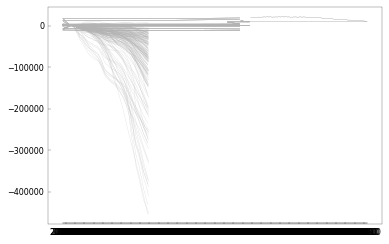

In [25]:
historical_filename = "AIS_historical_w_ctrl.pdf"
imbie_ant = load_imbie_ant()
plot_historical(historical_filename, df, imbie_ant)